## CS5187 Project code V3 ##

```sh
conda install -c conda-forge dataset
conda install -c conda-forge transformers=4.26.1
conda install -c conda-forge evaluate
conda install -c conda-forge albumentations
conda install -c conda-forge torchmetrics
```

In [1]:
from datasets import load_dataset
from huggingface_hub import hf_hub_download
from transformers import BeitImageProcessor, MaskFormerImageProcessor, SegformerImageProcessor, BeitForSemanticSegmentation, MaskFormerForInstanceSegmentation, SegformerForSemanticSegmentation, TrainingArguments, Trainer, pipeline
from torchvision.transforms import ColorJitter
import evaluate
from torchmetrics import Dice

import torch
import numpy as np
from torch import nn
import json
import matplotlib.pyplot as plt
import colorsys
import random
import os

In [2]:
g_dataset = "scene_parse_150"
g_pretrain_1 = "microsoft/beit-base-finetuned-ade-640-640"
g_pretrain_2 = "nvidia/segformer-b5-finetuned-ade-640-640"

g_label_repo_id = "huggingface/label-files"
g_label_filename = "ade20k-id2label.json"

g_modeldir_1 = "output/beit-base-scene-parse-150"
g_modeldir_2 = "output/segformer-b5-scene-parse-150"
g_logdir_1 = "logs/beit-base-scene-parse-150"
g_logdir_2 = "logs/segformer-b5-scene-parse-150"

g_trained_model = "output-v2/segformer-b5-scene-parse-150/checkpoint-9000"
g_result_json_1 = "output/scores-beit-base-ade.json"
g_result_json_2 = "output/scores-segformer-b5-scene-parse-150.json"
g_result_json_3 = {
    "floor": "output/scores-mixed-floor.json",
    "round": "output/scores-mixed-round.json",
    "ceil": "output/scores-mixed-ceil.json",
    "minimum": "output/scores-mixed-min.json",
    "maximum": "output/scores-mixed-max.json"
}

In [3]:
g_device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # use GPU if available, otherwise use a CPU
g_seed = 5187 * 5187

In [4]:
os.makedirs(os.path.dirname("output/"), exist_ok=True)  
os.makedirs(os.path.dirname("logs/"), exist_ok=True)  

In [5]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_random_seed(g_seed)

In [6]:
ds = load_dataset(g_dataset, split="train[:1000]")

No config specified, defaulting to: scene_parse_150/scene_parsing
Found cached dataset scene_parse_150 (C:/Users/User/.cache/huggingface/datasets/scene_parse_150/scene_parsing/1.0.0/d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75)


In [7]:
ds1 = ds.train_test_split(test_size=0.1)
train_ds1 = ds1["train"]
test_ds1 = ds1["test"]
ds2 = ds.train_test_split(test_size=0.1)
train_ds2 = ds2["train"]
test_ds2 = ds2["test"]

Loading cached split indices for dataset at C:\Users\User\.cache\huggingface\datasets\scene_parse_150\scene_parsing\1.0.0\d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75\cache-8678ddda9d49331a.arrow and C:\Users\User\.cache\huggingface\datasets\scene_parse_150\scene_parsing\1.0.0\d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75\cache-e7846b9c26425e7e.arrow
Loading cached split indices for dataset at C:\Users\User\.cache\huggingface\datasets\scene_parse_150\scene_parsing\1.0.0\d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75\cache-b4ee408792e501a8.arrow and C:\Users\User\.cache\huggingface\datasets\scene_parse_150\scene_parsing\1.0.0\d998c54e1b5c5bad12b4d2ec7e1a5f74eee4c153bc1b089a0001677ae9b3fd75\cache-32e8b7b44c77e30e.arrow


In [8]:
len(train_ds1)

900

In [9]:
test_ds1_annotation = [d['annotation'] for d in test_ds1]

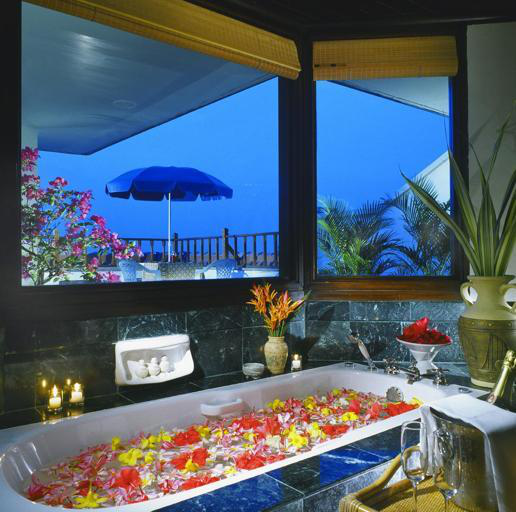

In [10]:
train_ds1[0]["image"]

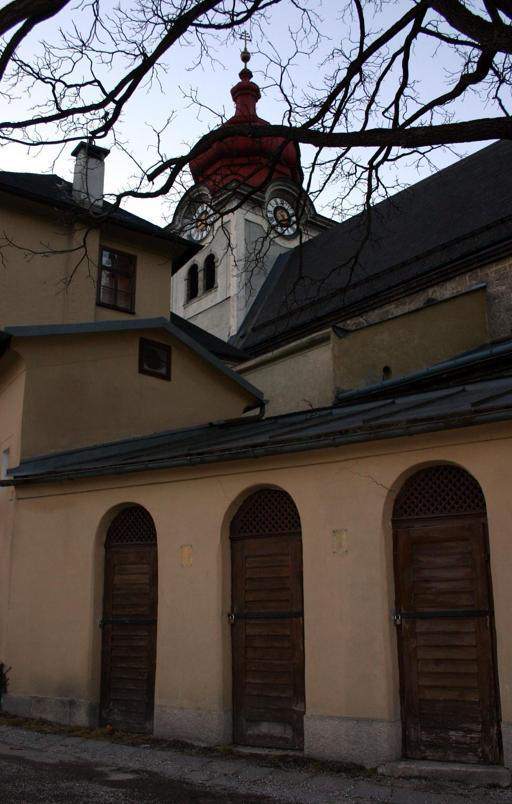

In [11]:
train_ds2[0]["image"]

In [12]:
id2label = json.load(open(hf_hub_download(repo_id=g_label_repo_id, filename=g_label_filename, repo_type="dataset"), "r"))
id2label = {int(k): v for k, v in id2label.items()}
label2id = {v: k for k, v in id2label.items()}
num_labels = len(id2label)

In [13]:
image_processor_1 = BeitImageProcessor.from_pretrained(g_pretrain_1, do_reduce_labels=True)
image_processor_2 = SegformerImageProcessor.from_pretrained(g_pretrain_2, do_reduce_labels=True)

c:\ProgramData\Miniconda3\envs\anifusion2-env\lib\site-packages\transformers\models\segformer\image_processing_segformer.py:102: FutureWarning: The `reduce_labels` parameter is deprecated and will be removed in a future version. Please use `do_reduce_labels` instead.
  warnings.warn(


In [14]:
jitter = ColorJitter(brightness=0.25, contrast=0.25, saturation=0.25, hue=0.1)

In [15]:
def train_transforms_1(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor_1(images, labels)
    return inputs

def val_transforms_1(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor_1(images, labels)
    return inputs

def train_transforms_2(example_batch):
    images = [jitter(x) for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor_2(images, labels)
    return inputs

def val_transforms_2(example_batch):
    images = [x for x in example_batch["image"]]
    labels = [x for x in example_batch["annotation"]]
    inputs = image_processor_2(images, labels)
    return inputs

In [16]:
train_ds1.set_transform(train_transforms_1)
test_ds1.set_transform(val_transforms_1)
train_ds2.set_transform(train_transforms_2)
test_ds2.set_transform(val_transforms_2)

In [17]:
metric_iou = evaluate.load("mean_iou")
metric_dice = Dice(average='micro')

In [18]:
def compute_metrics(eval_pred):
    with torch.no_grad():
        logits, labels = eval_pred
        logits_tensor = torch.from_numpy(logits)
        logits_tensor = nn.functional.interpolate(
            logits_tensor,
            size=labels.shape[-2:],
            mode="bilinear",
            align_corners=False,
        ).argmax(dim=1)

        pred_labels = logits_tensor.detach().cpu().numpy()
        metrics_iou = metric_iou.compute(
            predictions=pred_labels,
            references=labels,
            num_labels=num_labels,
            ignore_index=255,
            reduce_labels=False,
        )
        #metrics_dice = metric_dice(pred_labels, labels)

        for key, value in metrics_iou.items():
            if type(value) is np.ndarray:
                metrics_iou[key] = value.tolist()

        return metrics_iou #, metrics_dice

In [19]:
model_1 = BeitForSemanticSegmentation.from_pretrained(g_pretrain_1, id2label=id2label, label2id=label2id, ignore_mismatched_sizes=True)

In [20]:
model_2 = SegformerForSemanticSegmentation.from_pretrained(g_pretrain_2, id2label=id2label, label2id=label2id)

In [21]:
def get_training_args(output_dir, logging_dir, batch_size):
    return TrainingArguments (
        output_dir=output_dir,
        logging_dir=logging_dir,
        optim="adamw_torch",
        learning_rate=1e-6,
        num_train_epochs=10,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        save_total_limit=2,
        evaluation_strategy="steps",
        save_strategy="steps",
        save_steps=450,
        eval_steps=450,
        logging_steps=1,
        eval_accumulation_steps=5,
        remove_unused_columns=False,
        push_to_hub=False,
        report_to="all"
    )

trainer_1 = Trainer(
    model=model_1,
    args=get_training_args(g_modeldir_1, g_logdir_1, 1),
    train_dataset=train_ds1,
    eval_dataset=test_ds1,
    compute_metrics=compute_metrics,
)

trainer_2 = Trainer(
    model=model_2,
    args=get_training_args(g_modeldir_2, g_logdir_2, 1),
    train_dataset=train_ds2,
    eval_dataset=test_ds2,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices


In [22]:
#Model too large!
#trainer_1.train()

In [23]:
if g_trained_model is None:
    #41m20.3s
    trainer_2.train()
else:
    model_2 = SegformerForSemanticSegmentation.from_pretrained(g_trained_model, id2label=id2label, label2id=label2id)

loading configuration file output-v2/segformer-b5-scene-parse-150/checkpoint-9000\config.json
Model config SegformerConfig {
  "_name_or_path": "nvidia/segformer-b5-finetuned-ade-640-640",
  "architectures": [
    "SegformerForSemanticSegmentation"
  ],
  "attention_probs_dropout_prob": 0.0,
  "classifier_dropout_prob": 0.1,
  "decoder_hidden_size": 768,
  "depths": [
    3,
    6,
    40,
    3
  ],
  "downsampling_rates": [
    1,
    4,
    8,
    16
  ],
  "drop_path_rate": 0.1,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_sizes": [
    64,
    128,
    320,
    512
  ],
  "id2label": {
    "0": "wall",
    "1": "building",
    "2": "sky",
    "3": "floor",
    "4": "tree",
    "5": "ceiling",
    "6": "road",
    "7": "bed ",
    "8": "windowpane",
    "9": "grass",
    "10": "cabinet",
    "11": "sidewalk",
    "12": "person",
    "13": "earth",
    "14": "door",
    "15": "table",
    "16": "mountain",
    "17": "plant",
    "18": "curtain",
    "19": "chair",

In [24]:
def create_ade20k_label_colormap(size = 151):
    a = []
    for i in range(size):
        a.append(list(colorsys.hls_to_rgb(i / size, 0.5, 1.0)))
    return np.asarray(a) * 255

In [25]:
def draw_segmentation(image, image_processor, model):
    encoding = image_processor(image, return_tensors="pt")
    pixel_values = encoding.pixel_values.to(model.device)
    outputs = model(pixel_values=pixel_values)
    logits = outputs.masks_queries_logits.cpu() if isinstance(model, MaskFormerForInstanceSegmentation) else outputs.logits.cpu()
    upsampled_logits = nn.functional.interpolate(
        logits,
        size=image.size[::-1],
        mode="bilinear",
        align_corners=False,
    )

    pred_seg = upsampled_logits.argmax(dim=1)[0]
    print(pred_seg.shape)
    color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(create_ade20k_label_colormap())
    for label, color in enumerate(palette):
        color_seg[pred_seg == label, :] = color
    color_seg = color_seg[..., ::-1]  # convert to BGR

    img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

In [26]:
image_test_1 = ds[0]["image"]

In [27]:
image_test_2 = ds[0]["image"]

torch.Size([512, 683])


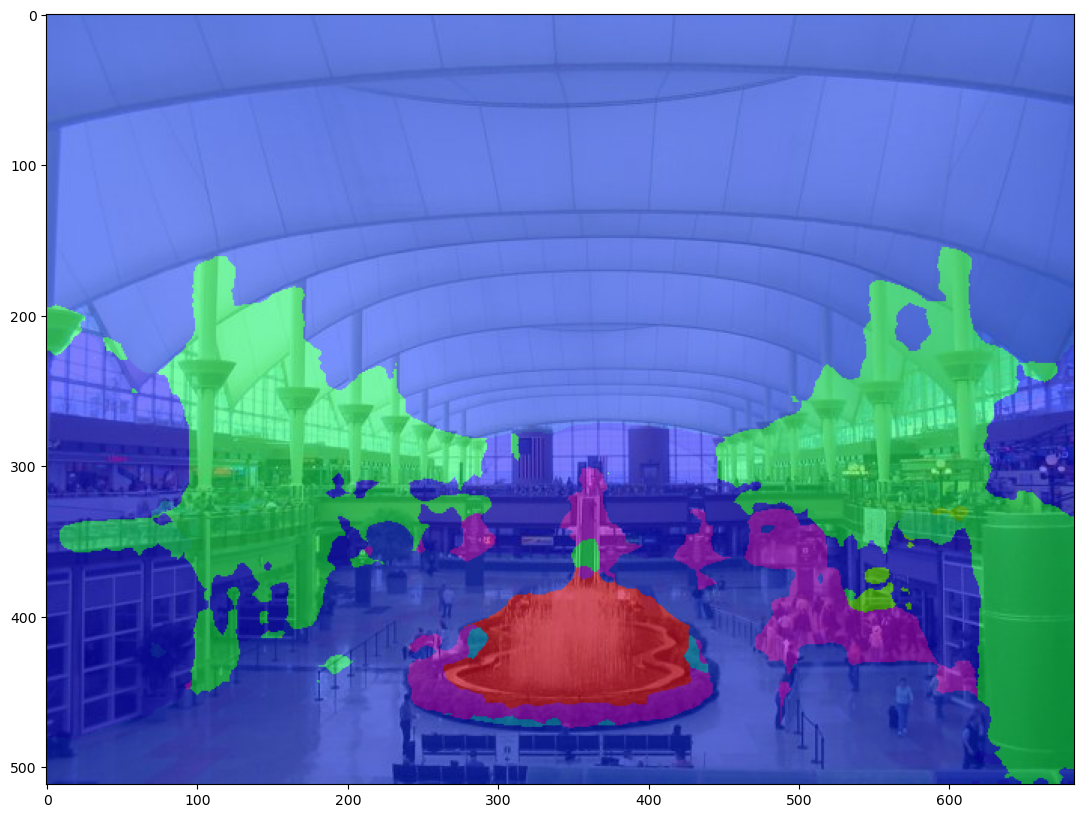

In [28]:
draw_segmentation(image_test_1, image_processor_1, model_1)

torch.Size([512, 683])


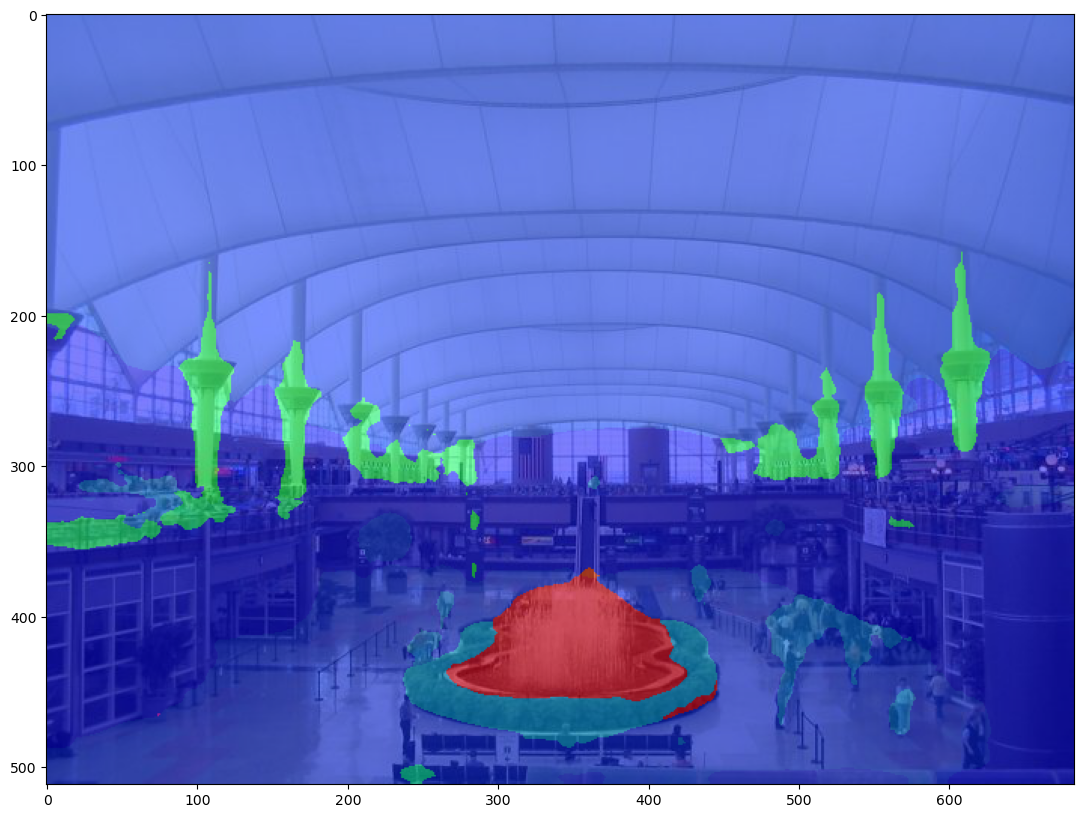

In [29]:
draw_segmentation(image_test_2, image_processor_2, model_2)

In [30]:
class NumpyEncoder(json.JSONEncoder):
    """ Special json encoder for numpy types """
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        elif isinstance(obj, np.floating):
            return float(obj)
        elif isinstance(obj, np.ndarray):
            return obj.tolist()
        return json.JSONEncoder.default(self, obj)
    
def compute_metrics_complete(test_ds, image_processor, model, result_json):
    with torch.no_grad():
        results = {
            "mean_iou": [],
            "mean_accuracy": [],
            "overall_accuracy": [],
            "metrics_dice": []
        }
            
        for i, batch in enumerate(test_ds):
            #if i > 1: 
            #    break
            #print(batch.keys())
            #print(batch["pixel_values"].shape)
            if isinstance(model, MaskFormerForInstanceSegmentation):
                # Not working  
                encoding = image_processor(batch["pixel_values"], return_tensors="pt")
                pixel_values = encoding.pixel_values.to(model.device)
                pred = model(pixel_values=pixel_values)
                
                # Get ground truth semantic segmentation map
                annotation = np.array(test_ds1_annotation[i]) #[...,0]
                #print(annotation.shape)
                # Replace null class (0) with the ignore_index (255) and reduce labels
                annotation -= 1
                annotation[annotation==-1] = 255
                labels = annotation

                target_size = pixel_values.size()[::-1] #batch["pixel_values"].shape[::-1] 
                #print(target_size)
                result = image_processor.post_process_semantic_segmentation(pred)[0] #,target_sizes=[target_size]
                #semantic_seg_mask = result.cpu().detach().numpy()
                #print(result.size())
                #print(labels.shape[-2:])

                logits_tensor = nn.functional.interpolate(
                    result,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False,
                ).argmax(dim=1)
                
                pred_labels = logits_tensor.cpu().detach().numpy()
            else:
                encoding = image_processor(batch["pixel_values"], return_tensors="pt")
                pixel_values = encoding.pixel_values.to(model.device)
                pred = model(pixel_values=pixel_values)
                logits = pred["logits"]
                #print(logits.size())
                labels = np.array([batch["labels"]])
                logits_tensor = logits
                logits_tensor = nn.functional.interpolate(
                    logits_tensor,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False,
                ).argmax(dim=1)
                pred_labels = logits_tensor.detach().cpu().numpy()

            #print(labels)

            metrics_iou = metric_iou.compute(
                predictions=pred_labels,
                references=labels,
                num_labels=num_labels,
                ignore_index=255,
                reduce_labels=False,
            )
            metrics_dice = metric_dice(torch.from_numpy(pred_labels), torch.from_numpy(labels))
            metrics_dice = metrics_dice.detach().cpu().numpy()

            for key, value in metrics_iou.items():
                if type(value) is np.ndarray:
                    metrics_iou[key] = value.tolist()

            #print(metrics_iou)
            #print({'metrics_dice': metrics_dice})
            results["mean_iou"].append(metrics_iou["mean_iou"])
            results["mean_accuracy"].append(metrics_iou["mean_accuracy"])
            results["overall_accuracy"].append(metrics_iou["overall_accuracy"])
            results["metrics_dice"].append(metrics_dice)

        json_result = {
            "mean_iou": np.mean(np.array(results["mean_iou"])),
            "mean_accuracy": np.mean(np.array(results["mean_accuracy"])),
            "overall_accuracy": np.mean(np.array(results["overall_accuracy"])),
            "metrics_dice": np.mean(np.array(results["metrics_dice"]))
        }

        print(json_result)

        # Directly from dictionary
        with open(result_json, 'w', encoding='utf-8') as outfile:
            json.dump(json_result, outfile, ensure_ascii=False, indent=4, cls=NumpyEncoder)

In [31]:
compute_metrics_complete(test_ds1, image_processor_1, model_1, g_result_json_1)

C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
C:\Users\User\.cache\huggingface\modules\evaluate_modules\metrics\evaluate-metric--mean_iou\08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9\mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


{'mean_iou': 0.03819738547377278, 'mean_accuracy': 0.04653962841508155, 'overall_accuracy': 0.8326190669492333, 'metrics_dice': 0.79509455}


In [32]:
compute_metrics_complete(test_ds2, image_processor_2, model_2, g_result_json_2)

{'mean_iou': 0.4100645731424512, 'mean_accuracy': 0.5444509090193671, 'overall_accuracy': 0.7772611401620861, 'metrics_dice': 0.74732}


In [33]:
def draw_segmentation_ensemble(image, image_processors, models):
    pred_sum = None
    pred_arr = []

    for i in range(len(models)):
        encoding = image_processors[i](image, return_tensors="pt")
        pixel_values = encoding.pixel_values.to(models[i].device)
        outputs = models[i](pixel_values=pixel_values)
        logits = outputs.masks_queries_logits.cpu() if isinstance(models[i], MaskFormerForInstanceSegmentation) else outputs.logits.cpu() 
        
        upsampled_logits = nn.functional.interpolate(
            logits,
            size=image.size[::-1],
            mode="bilinear",
            align_corners=False,
        )

        pred_seg_subset = upsampled_logits.argmax(dim=1)[0]
        pred_sum = pred_seg_subset if pred_sum is None else pred_sum + pred_seg_subset
        pred_arr.append(pred_seg_subset)
    
    #Naive elementise average
    #pred_seg = torch.ceil(pred_sum / len(models)).to(torch.uint8)
    pred_seg = torch.minimum(*pred_arr).to(torch.uint8)
    #print(pred_seg.min(), pred_seg.max())
    color_seg = np.zeros((pred_seg.shape[0], pred_seg.shape[1], 3), dtype=np.uint8)
    palette = np.array(create_ade20k_label_colormap())
    for label, color in enumerate(palette):
        color_seg[pred_seg == label, :] = color
    color_seg = color_seg[..., ::-1]  # convert to BGR

    img = np.array(image) * 0.5 + color_seg * 0.5  # plot the image with the segmentation map
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

In [34]:
image_test_3 = ds[0]["image"]

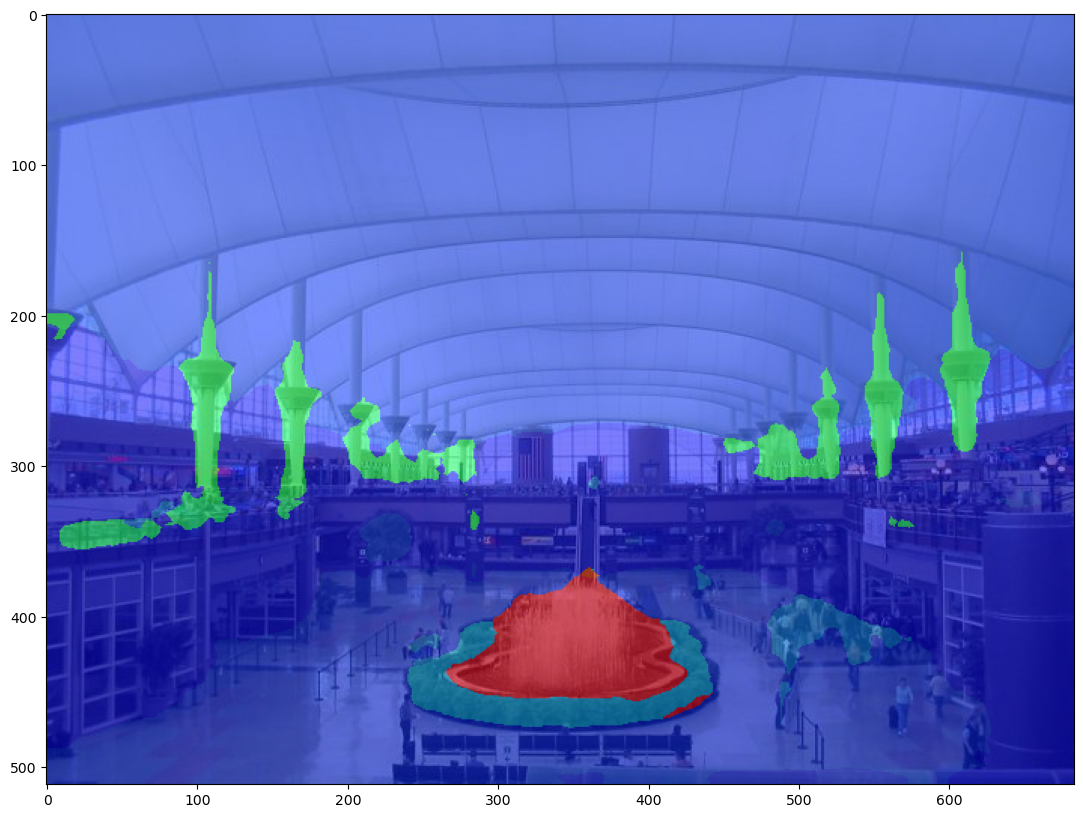

In [35]:
draw_segmentation_ensemble(image_test_3, [image_processor_1, image_processor_2], [model_1, model_2])

In [36]:
def compute_metrics_complete_ensemble(mappings, master_dataset, g_result_json, combine_opt="floor"):
    with torch.no_grad():
        results = {
            "mean_iou": [],
            "mean_accuracy": [],
            "overall_accuracy": [],
            "metrics_dice": []
        }
            
        for i, batch_master in enumerate(master_dataset):
            #if i > 0: 
            #    break
            #print(batch.keys())
            #print(batch["pixel_values"].shape)
            label_master = batch_master["labels"]
            labels = np.array([label_master])
            pred_labels_sum = None
            pred_labels_arr = []

            for mapping in mappings:
                image_processor = mapping["image_processor"]
                model = mapping["model"]
                test_ds = mapping["test_ds"]

                encoding = image_processor(test_ds[i]["pixel_values"], return_tensors="pt")
                pixel_values = encoding.pixel_values.to(model.device)
                pred = model(pixel_values=pixel_values)
                logits = pred["logits"]
                #print(logits.size())                
                logits_tensor = logits
                logits_tensor = nn.functional.interpolate(
                    logits_tensor,
                    size=labels.shape[-2:],
                    mode="bilinear",
                    align_corners=False,
                ).argmax(dim=1)
                pred_labels_single = logits_tensor.detach().cpu().numpy()
                #print(pred_labels_single)        
                pred_labels_sum = pred_labels_single if pred_labels_sum is None else pred_labels_sum + pred_labels_single
                pred_labels_arr.append(pred_labels_single)

            #print(labels)

            if combine_opt == "floor":
                pred_labels = np.floor (pred_labels_sum / len(mappings)).astype(np.uint8)
            elif combine_opt == "ceil":
                pred_labels = np.ceil(pred_labels_sum / len(mappings)).astype(np.uint8)
            elif combine_opt == "round":
                pred_labels = np.round(pred_labels_sum / len(mappings)).astype(np.uint8)
            elif combine_opt == "minimum":
                pred_labels = np.minimum(*pred_labels_arr).astype(np.uint8)
            elif combine_opt == "maximum":
                pred_labels = np.maximum(*pred_labels_arr).astype(np.uint8)
            else:
                pred_labels = np.floor (pred_labels_sum / len(mappings)).astype(np.uint8)
            
            #pred_labels = combine_fnc(pred_labels_sum / len(mappings)).astype(np.uint8)

            metrics_iou = metric_iou.compute(
                predictions=pred_labels,
                references=labels,
                num_labels=num_labels,
                ignore_index=255,
                reduce_labels=False,
            )
            metrics_dice = metric_dice(torch.from_numpy(pred_labels), torch.from_numpy(labels))
            metrics_dice = metrics_dice.detach().cpu().numpy()

            for key, value in metrics_iou.items():
                if type(value) is np.ndarray:
                    metrics_iou[key] = value.tolist()

            #print(metrics_iou)
            #print({'metrics_dice': metrics_dice})
            results["mean_iou"].append(metrics_iou["mean_iou"])
            results["mean_accuracy"].append(metrics_iou["mean_accuracy"])
            results["overall_accuracy"].append(metrics_iou["overall_accuracy"])
            results["metrics_dice"].append(metrics_dice)

        json_result = {
            "mean_iou": np.mean(np.array(results["mean_iou"])),
            "mean_accuracy": np.mean(np.array(results["mean_accuracy"])),
            "overall_accuracy": np.mean(np.array(results["overall_accuracy"])),
            "metrics_dice": np.mean(np.array(results["metrics_dice"]))
        }

        print(json_result)

        # Directly from dictionary
        with open(g_result_json, 'w', encoding='utf-8') as outfile:
            json.dump(json_result, outfile, ensure_ascii=False, indent=4, cls=NumpyEncoder)

In [37]:
for c_opt in g_result_json_3.keys():
    compute_metrics_complete_ensemble(mappings = [{
        "test_ds": test_ds1,
        "image_processor": image_processor_1,
        "model": model_1
    },{
        "test_ds": test_ds2,
        "image_processor": image_processor_2,
        "model": model_2
    }], master_dataset=test_ds2, g_result_json=g_result_json_3[c_opt], combine_opt=c_opt)

{'mean_iou': 0.022637282328963445, 'mean_accuracy': 0.08375961930985877, 'overall_accuracy': 0.1617648581279613, 'metrics_dice': 0.1524889}
{'mean_iou': 0.02294236112941693, 'mean_accuracy': 0.0786273911938121, 'overall_accuracy': 0.15993716458570706, 'metrics_dice': 0.1509993}
{'mean_iou': 0.020897207994607373, 'mean_accuracy': 0.07874157440722768, 'overall_accuracy': 0.15486921426559744, 'metrics_dice': 0.1472792}
{'mean_iou': 0.1393452992282758, 'mean_accuracy': 0.25592671786416205, 'overall_accuracy': 0.5089223975766878, 'metrics_dice': 0.48896554}
{'mean_iou': 0.17159357310208934, 'mean_accuracy': 0.37452806976278263, 'overall_accuracy': 0.4374181125048696, 'metrics_dice': 0.4193083}
